In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
nifty = pd.read_csv('../historical/NIFTY50_day.csv', parse_dates=['Date'], date_parser=dateparse)
nifty.head(5)

,TIME,Open,High,Low,Close,VOLUME,SYMBOL,Date,TIME1
0,2015-01-01 00:00:00,8272.79,8294.70,8248.75,8284.00,0,NIFTY%2050,2015-01-01,00:00:00
1,2015-01-02 00:00:00,8288.70,8410.60,8288.70,8395.45,0,NIFTY%2050,2015-01-02,00:00:00
2,2015-01-05 00:00:00,8407.95,8445.60,8363.90,8378.40,0,NIFTY%2050,2015-01-05,00:00:00
3,2015-01-06 00:00:00,8325.29,8327.85,8111.35,8127.35,0,NIFTY%2050,2015-01-06,00:00:00
4,2015-01-07 00:00:00,8118.65,8151.20,8065.45,8102.10,0,NIFTY%2050,2015-01-07,00:00:00


# I. Daily 

## Daily range

In [3]:
dailyRange = nifty.High - nifty.Low

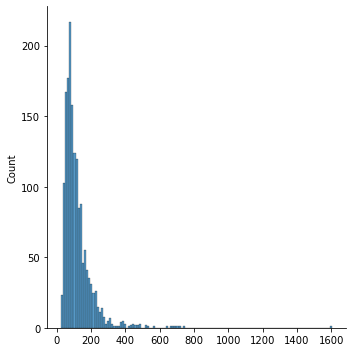

In [4]:
sns.displot(dailyRange)
plt.show()

In [5]:
dailyRange = np.delete(np.array(dailyRange), 1328) # Taking out the outlier by index

In [6]:
np.percentile(dailyRange, [25, 50, 85, 95])

array([ 69.5875,  95.325 , 175.35  , 254.6   ])

In [7]:
print("1 Sigma: ", round(np.std(dailyRange) + np.mean(dailyRange)))
print("2 Sigma: ", round(2 * np.std(dailyRange) + np.mean(dailyRange)))
print("3 Sigma: ", round(3 * np.std(dailyRange) + np.mean(dailyRange)))

1 Sigma:  200
2 Sigma:  281
3 Sigma:  362


#### 68% (1 sigma) of the daily range confined within 200 points

## Gaps

In [8]:
gaps = []
for i in range(nifty.shape[0]-1):
    gaps.append(round(nifty.Close[i] - nifty.Open[i+1]))

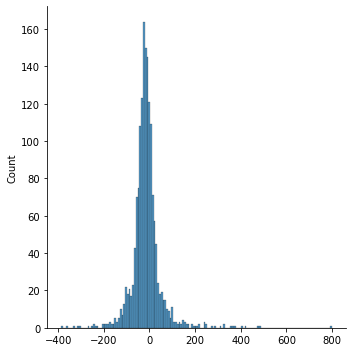

In [9]:
sns.displot(gaps)
plt.show()

In [10]:
gaps = np.delete(np.array(gaps), np.where(gaps == 800)) # Taking out the outlier by value

In [11]:
np.percentile(gaps, [25, 50, 85])

array([-40. , -17.5,  23. ])

In [12]:
print("1 Sigma above: ", round(np.std(gaps) + np.mean(gaps)), 
      "|| 1 Sigma below: ", round(- np.std(gaps) + np.mean(gaps)))
print("2 Sigma above: ", round(2 * np.std(gaps) + np.mean(gaps)), 
      "|| 2 Sigma below: ", round(- 2 * np.std(gaps) + np.mean(gaps)))
print("3 Sigma above: ", round(3 * np.std(gaps) + np.mean(gaps)), 
      "|| 3 Sigma below: ", round(- 3 * np.std(gaps) + np.mean(gaps)))

1 Sigma above:  54 || 1 Sigma below:  -82
2 Sigma above:  122 || 2 Sigma below:  -151
3 Sigma above:  190 || 3 Sigma below:  -219


#### 68% (1 sigma) of the time, gap up is 50 points and gap down is 80 points

# II. Weekly: Mon - Fri
Range has been taken from last Friday closing to this Friday closing

In [13]:
wI = nifty.Date.dt.weekday
wI = wI.iloc[2:] # Ignoring starting two days 

In [14]:
weekStart = wI[np.insert((np.diff(wI) < 0), 0, True)].index

In [15]:
weekRangedown = []
weekRangeup = []
for i in range(weekStart.shape[0] - 1):
    startingValue = nifty.loc[weekStart[i] - 1, 'Close']    
    weekOHLC = nifty.loc[weekStart[i]:weekStart[i+1] - 1, ['Open', 'High', 'Low', 'Close']]
    weekMax = weekOHLC.max().max()
    weekMin = weekOHLC.min().min()
    if (startingValue < weekMin) and (startingValue < weekMax):
        weekRangeup.append(round(weekMax - startingValue))
    elif (startingValue > weekMin) and (startingValue < weekMax):
        weekRangeup.append(round(weekMax - startingValue))
        weekRangedown.append(round(weekMin - startingValue))        
    elif (startingValue > weekMin) and (startingValue > weekMax):    
        weekRangedown.append(round(weekMin - startingValue))

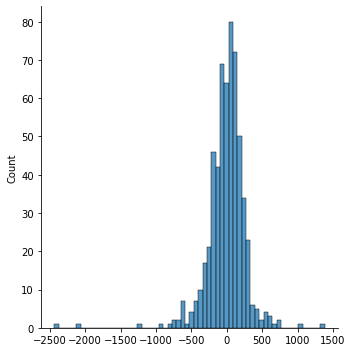

In [16]:
sns.displot(np.concatenate((weekRangeup, weekRangedown)))
plt.show()

In [17]:
weekRangedown = np.delete(weekRangedown, np.where(weekRangedown == -2434)) # Taking out the outlier
weekRangedown = np.delete(weekRangedown, np.where(weekRangedown == -2123)) # Taking out the outlier

In [18]:
print(np.percentile(weekRangeup, [25, 50, 85, 95]))
print(np.percentile(weekRangedown, [25, 50, 85, 95]))

[ 63.  138.  281.7 420.3]
[-231.  -133.   -33.4  -13.8]


In [19]:
print("1 Sigma above: ", round(np.std(weekRangeup) + np.mean(weekRangeup)), 
      "|| 1 Sigma below: ", round(- np.std(weekRangedown) + np.mean(weekRangedown)))
print("2 Sigma above: ", round(2 * np.std(weekRangeup) + np.mean(weekRangeup)), 
      "|| 2 Sigma below: ", round(- 2 * np.std(weekRangedown) + np.mean(weekRangedown)))
print("3 Sigma above: ", round(3 * np.std(weekRangeup) + np.mean(weekRangeup)), 
      "|| 3 Sigma below: ", round(- 3 * np.std(weekRangedown) + np.mean(weekRangedown)))

1 Sigma above:  327 || 1 Sigma below:  -406
2 Sigma above:  484 || 2 Sigma below:  -627
3 Sigma above:  642 || 3 Sigma below:  -848


#### 68% of the time, Nifty can travel 350 points up and 400 points down in a week

# III. Weekly: Thursday - Thursday
Range has been taken from last Wednesday closing to this Thursday closing

In [20]:
wI = nifty.Date.dt.weekday
Tstart = wI[wI - 3 == 0].index

In [21]:
TweekRangeUp = []
TweekRangeDown = []
for i in range(1, Tstart.shape[0]-1):    
    startingValue = nifty.loc[Tstart[i] - 1, 'Close']    
    weekOHLC = nifty.loc[Tstart[i]:Tstart[i+1] , ['Open', 'High', 'Low', 'Close']]
    weekMax = weekOHLC.max().max()
    weekMin = weekOHLC.min().min()    
    
    if (startingValue < weekMin) and (startingValue < weekMax):
        TweekRangeUp.append(round(weekMax - startingValue))
    elif (startingValue > weekMin) and (startingValue < weekMax):
        TweekRangeUp.append(round(weekMax - startingValue))
        TweekRangeDown.append(round(weekMin - startingValue))        
    elif (startingValue > weekMin) and (startingValue > weekMax):    
        TweekRangeDown.append(round(weekMin - startingValue))

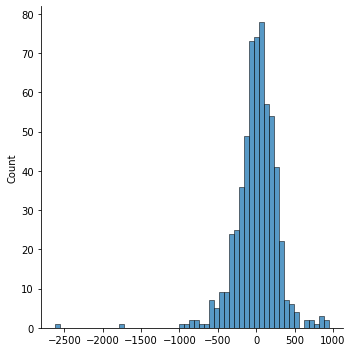

In [22]:
sns.displot(np.concatenate((TweekRangeUp, TweekRangeDown)))
plt.show()

In [23]:
TweekRangeDown = np.delete(TweekRangeDown, np.where(TweekRangeDown == -2626)) # Taking out the outlier
TweekRangeDown = np.delete(TweekRangeDown, np.where(TweekRangeDown == -1761)) # Taking out the outlier

In [24]:
print(np.percentile(TweekRangeUp, [25, 50, 85, 95]))
print(np.percentile(TweekRangeDown, [25, 50, 85, 95]))

[ 72.5 157.  302.1 466.7]
[-256.75 -119.5   -27.65   -8.  ]


In [25]:
print("1 Sigma above: ", round(np.std(TweekRangeUp) + np.mean(TweekRangeUp)), 
      "|| 1 Sigma below: ", round(- np.std(TweekRangeDown) + np.mean(TweekRangeDown)))
print("2 Sigma above: ", round(2 * np.std(TweekRangeUp) + np.mean(TweekRangeUp)), 
      "|| 2 Sigma below: ", round(- 2 * np.std(TweekRangeDown) + np.mean(TweekRangeDown)))
print("3 Sigma above: ", round(3 * np.std(TweekRangeUp) + np.mean(TweekRangeUp)), 
      "|| 3 Sigma below: ", round(- 3 * np.std(TweekRangeDown) + np.mean(TweekRangeDown)))

1 Sigma above:  347 || 1 Sigma below:  -415
2 Sigma above:  507 || 2 Sigma below:  -642
3 Sigma above:  668 || 3 Sigma below:  -869


#### NIFTY can move +350/-400  points 68% of the time

# IV. Monthly

In [26]:
idx = nifty[np.insert(np.diff(pd.to_datetime(nifty.TIME).dt.month) == 1, 0, True)].index

In [27]:
monthRangeUp = []
monthRangeDown = []
for i in range(1, idx.shape[0]-1):   
    startingValue = nifty.loc[idx[i] - 1].Close    
    monthOHLC = nifty.loc[idx[i]:idx[i+1] - 1, ['Open', 'High', 'Low', 'Close']]
    monthMax = monthOHLC.max().max()
    monthMin = monthOHLC.min().min()  
    if (startingValue < monthMax) & (startingValue < monthMin):
        monthRangeUp.append(round(monthMax - startingValue))
    elif (startingValue < monthMax) & (startingValue > monthMin):
        monthRangeUp.append(round(monthMax - startingValue))
        monthRangeDown.append(round(monthMin - startingValue))
    elif (startingValue > monthMax) & (startingValue > monthMin):        
        monthRangeDown.append(round(monthMin - startingValue))


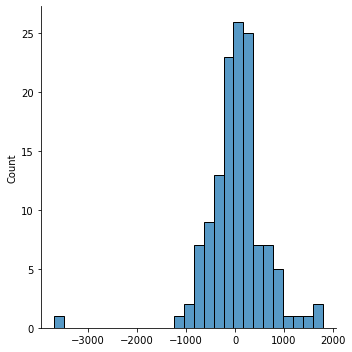

In [28]:
sns.displot(np.concatenate((monthRangeUp, monthRangeDown)))
plt.show()

In [29]:
monthRangeDown = np.delete(monthRangeDown, np.where(monthRangeDown == -3691)) # Taking out the outlier

In [30]:
print(np.percentile(monthRangeUp, [25, 50, 85, 95]))
print(np.percentile(monthRangeDown, [25, 50, 85, 95]))

[ 153.25  285.5   775.15 1202.8 ]
[-541.5 -245.   -47.4   -7.2]


In [31]:
print("1 Sigma above: ", round(np.std(monthRangeUp) + np.mean(monthRangeUp)), 
      "|| 1 Sigma below: ", round(- np.std(monthRangeDown) + np.mean(monthRangeDown)))
print("2 Sigma above: ", round(2 * np.std(monthRangeUp) + np.mean(monthRangeUp)), 
      "|| 2 Sigma below: ", round(- 2 * np.std(monthRangeDown) + np.mean(monthRangeDown)))
print("3 Sigma above: ", round(3 * np.std(monthRangeUp) + np.mean(monthRangeUp)), 
      "|| 3 Sigma below: ", round(- 3 * np.std(monthRangeDown) + np.mean(monthRangeDown)))

1 Sigma above:  799 || 1 Sigma below:  -887
2 Sigma above:  1191 || 2 Sigma below:  -1387
3 Sigma above:  1584 || 3 Sigma below:  -1886


#### NIFTY moves +800/-600 points in a month up or down 68% of the time